# Введение

Эксперимент посвящен анализу производительности алгоритма решения задачи достижимости между всеми парами вершин и с заданным множеством стартовых вершин с регулярными ограничениями через.

Исследуются следующие задачи достижимости, решаемые в предыдущих работах.

- Достижимость между всеми парами вершин.
- Достижимость для каждой из заданного множества стартовых вершин.

Вопросы, на которые необходимо ответить в ходе исследования.

- Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
- Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

# Описание алгоритмов

Первый алгоритм — алгоритм регулярных запросов через тензорное произведение, представляющий собой алгоритм достижимости между всеми парами вершин. Его реализация находится в `project/task3.py`.

```python
def tensor_based_rpq(
    regex: str,
    graph: MultiDiGraph,
    start_nodes: set[int],
    final_nodes: set[int],
    matrix_type: Type[spmatrix] = csr_matrix,
) -> set[tuple[int, int]]:
    ...
```

Второй алгоритм — алгоритм регулярных запросов, основанный на msBFS, через линейную алгебру, представляющий собой алгоритм достижимости между для нескольких стартовых вершин. Его реализация находится в `project/task4.py`.

```python
def ms_bfs_based_rpq(
    regex: str,
    graph: MultiDiGraph,
    start_nodes: set[int],
    final_nodes: set[int],
    matrix_type: spmatrix = csr_matrix,
) -> set[tuple[int, int]]:
    ...
```

# Описание набора данных для экспериментов

## Графы

В качестве графов были взяты следующие:

- [skos](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/skos.html#skos) — 144 вершин, 252 ребра.
- [generations](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/generations.html#generations) — 129 вершин, 273 ребра.
- [core](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/core.html#core) — 1323 вершины, 2752 ребра.
- [pizza](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/data/core.html#core) — 671 вершины, 1980 ребра.

Для сравнений взяты графы, размеры которых отличается на порядок: размеры первых двух и последних двух одного порядка, но между собой эти двойки отличаются в размере на порядок. Большая разница в размерах может помочь явно отразить сильные и слабые стороны рассматриваемых алгоритмов.

## Регулярные ограничения

В качестве регулярных ограничений были взяты следующие:

- ({l0} | {l1}) {l2}\* «простое» регулярное выражение
- ({l0} {l2}) ({l1} | {l3})\* «простое» регулярное выражение
- {l0}+ {l3}\* «сложное» регулярное выражение
- ({l1} | {l2})+ ({l0} | {l1})\* «сложное» регулярное выражение

В качестве меток будем брать наиболее часто встречающиеся, где l0 — наиболее частая.

# Детали работы

### Оборудование

Испытания проводились c процессором AMD Ryzen 5 5500U (6 ядер по 2 потока с 2.1 ГГц), 16GB RAM (3200 МГц) и ОС Ubuntu 22 (WSL2 на Windows 11).

### Ход эксперимента

1. <b>Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?</b><br/><br/>scikit предоставляет множество форматов хранения разреженных матриц. В этой работе будут рассмотрены следующие: [csr_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix), [csc_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csc_matrix.html#scipy.sparse.csc_matrix), [dok_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.dok_matrix.html#scipy.sparse.dok_matrix), [lil_matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html#scipy.sparse.lil_matrix).
   Ожидается, что CSR и CSC покажут наилучшие результаты, поскольку они оптимизированы для эффективных операций над разреженными матрицами. DOK и LIL могут оказаться менее эффективными из-за особенностей их структуры, особенно на больших графах.

2. <b>Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?</b><br/><br/>Гипотеза: пороговое значение для стартовых множеств будет зависеть от размера графа и «сложности» регулярных выражений.
   Для исследования этого вопроса нужно подобрать такой размер стартового множества, при котором производительность решения выше. Попробуем подбирать размеры стартовых множеств, и собирать данные о производительности алгоритмов, в зависимости от этого параметра.


# Эксперимент


In [16]:
%rye install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [33]:
from collections import Counter
from functools import cache
import time
from typing import Callable, Type, TypeAlias

import matplotlib.pyplot as plt
import cfpq_data
from cfpq_data import generate_multiple_source_percent
from networkx import MultiDiGraph
from scipy.sparse import csr_matrix, csc_matrix, dok_matrix, lil_matrix, spmatrix
import numpy as np
import logging

from project.task3 import tensor_based_rpq
from project.task4 import ms_bfs_based_rpq

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

MATRIX_TYPES = [csr_matrix, csc_matrix, dok_matrix, lil_matrix]
N = 10
REGEXES = [
    "({l0} | {l1}) {l2}*",
    "({l0} {l2}) ({l1} | {l3})*",
    "{l0}+ {l3}*",
    "({l1} | {l2})+ ({l0} | {l1})*",
]
NUMBER_OF_MOST_COMMON_LABELS = 4

SEED = 42

GraphName: TypeAlias = str


def subst_regex_pattern_to_most_common_labels(
    regex: str, most_common_labels: list
) -> str:
    subst = {}
    for i_label, label in enumerate(most_common_labels[:NUMBER_OF_MOST_COMMON_LABELS]):
        if f"l{i_label}" in regex:
            subst[f"l{i_label}"] = label
    return regex.format(**subst)


def calc_common_labels(graph: MultiDiGraph):
    _, _, labels = zip(*graph.edges(data="label"))
    most_common_labels, _ = zip(
        *Counter(labels).most_common(NUMBER_OF_MOST_COMMON_LABELS)
    )
    return most_common_labels


def get_graph_by_name(graph_name: str) -> MultiDiGraph:
    graph_path = cfpq_data.download(graph_name)
    return cfpq_data.graph_from_csv(graph_path)


@cache
def run_rpq(graph_name: GraphName, percent_of_start_states: float):
    graph = get_graph_by_name(graph_name)
    time_results: list = []

    def run_on_specific_regex(
        graph: MultiDiGraph, regex: str, matrix_type: Type[spmatrix]
    ) -> tuple[float, float]:
        kwargs = {
            "regex": regex,
            "graph": graph,
            "start_nodes": generate_multiple_source_percent(
                graph=graph, percent=percent_of_start_states, seed=SEED
            ),
            "final_nodes": None,
            "matrix_type": matrix_type,
        }

        def run_and_measure(rpq: Callable) -> float:
            start_time = time.time()
            _ = rpq(**kwargs)
            end_time = time.time()
            return end_time - start_time

        tensor_res = np.array([run_and_measure(tensor_based_rpq) for _ in range(N)])
        ms_bfs_res = np.array([run_and_measure(ms_bfs_based_rpq) for _ in range(N)])

        def reject_outliers(data, m=2.0):
            d = np.abs(data - np.median(data))
            mdev = np.median(d)
            s = d / mdev if mdev else np.zeros(len(d))
            return data[s < m]

        MILLISECONDS_PER_SECOND = 1000
        tensor_res = reject_outliers(tensor_res * MILLISECONDS_PER_SECOND)
        ms_bfs_res = reject_outliers(ms_bfs_res * MILLISECONDS_PER_SECOND)
        return (
            (np.median(tensor_res), np.std(tensor_res)),
            (np.median(ms_bfs_res), np.std(ms_bfs_res)),
        )

    most_common_labels = calc_common_labels(graph)
    for regex in map(
        lambda regex_pattern: subst_regex_pattern_to_most_common_labels(
            regex_pattern, most_common_labels
        ),
        REGEXES,
    ):
        time_result = list(
            map(
                lambda matrix_type: run_on_specific_regex(
                    graph=graph, regex=regex, matrix_type=matrix_type
                ),
                MATRIX_TYPES,
            )
        )
        time_results.append(time_result)
    return time_results


def run_and_visualize_result(graph_name: str, percent_of_start_states: float):
    time_results = run_rpq(
        graph_name=graph_name, percent_of_start_states=percent_of_start_states
    )
    matrix_type_results = zip(*time_results)

    fig, ax = plt.subplots()
    index = np.arange(len(REGEXES))
    bar_width = 0.1
    for i, matrix_type_result in enumerate(matrix_type_results):
        tensor_results, ms_bfs_results = zip(*matrix_type_result)
        tensor_mean, tensor_std = zip(*tensor_results)
        ms_bfs_mean, ms_bfs_std = zip(*ms_bfs_results)
        name_of_matrix_type = MATRIX_TYPES[i].__name__
        ax.bar(
            index + 2 * i * bar_width,
            tensor_mean,
            yerr=tensor_std,
            width=bar_width,
            label=f"tensor based ({name_of_matrix_type})",
            color="slateblue",
        )
        ax.bar(
            index + (2 * i + 1) * bar_width,
            ms_bfs_mean,
            yerr=ms_bfs_std,
            width=bar_width,
            label=f"ms bfs based ({name_of_matrix_type})",
            color="lightsalmon",
        )
    WIDTH_SIZE, HEIGHT_SIZE = 15, 10
    fig.set_figwidth(WIDTH_SIZE)
    fig.set_figheight(HEIGHT_SIZE)
    ax.set_xlabel("Regex")
    ax.set_ylabel("Time (ms.)")
    ax.set_title(
        f"{graph_name} result (percent of start states={percent_of_start_states})"
    )
    ax.set_xticks(index + bar_width * len(MATRIX_TYPES) * 2 / 2)
    ax.set_xticklabels(REGEXES)
    ax.legend()

Следующие графики отражают производительность алгоритмов с разными форматами разреженных матриц с разными регулярными ограничениями. В углу диаграмм есть сноска с конфигурацией запуска — список сверху вниз, соответсвующие конфигурациям столбцы идут соотвественно слева направо. Черной чертой обозначается среднее отклонение.


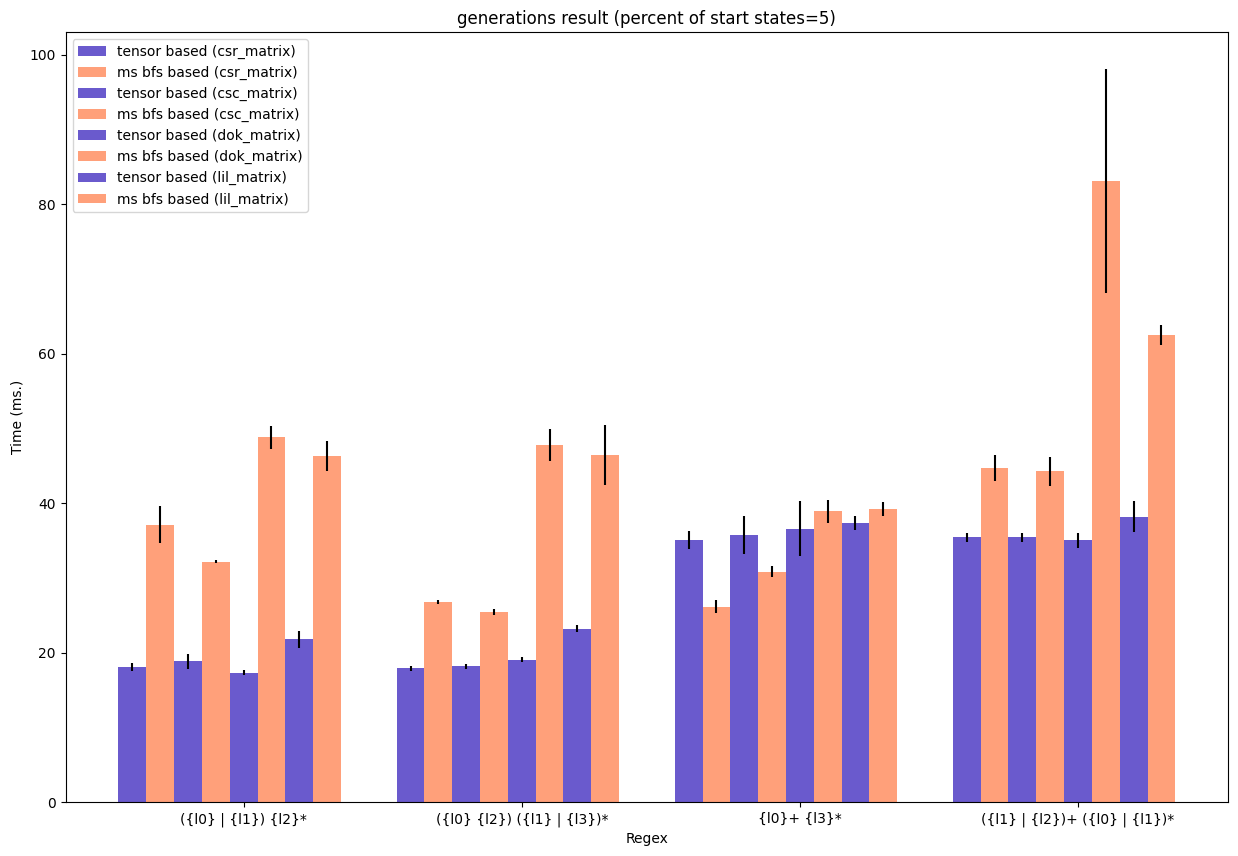

In [43]:
GRAPH_NAME = "generations"
PERCENT_OF_START_STATES = 5
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

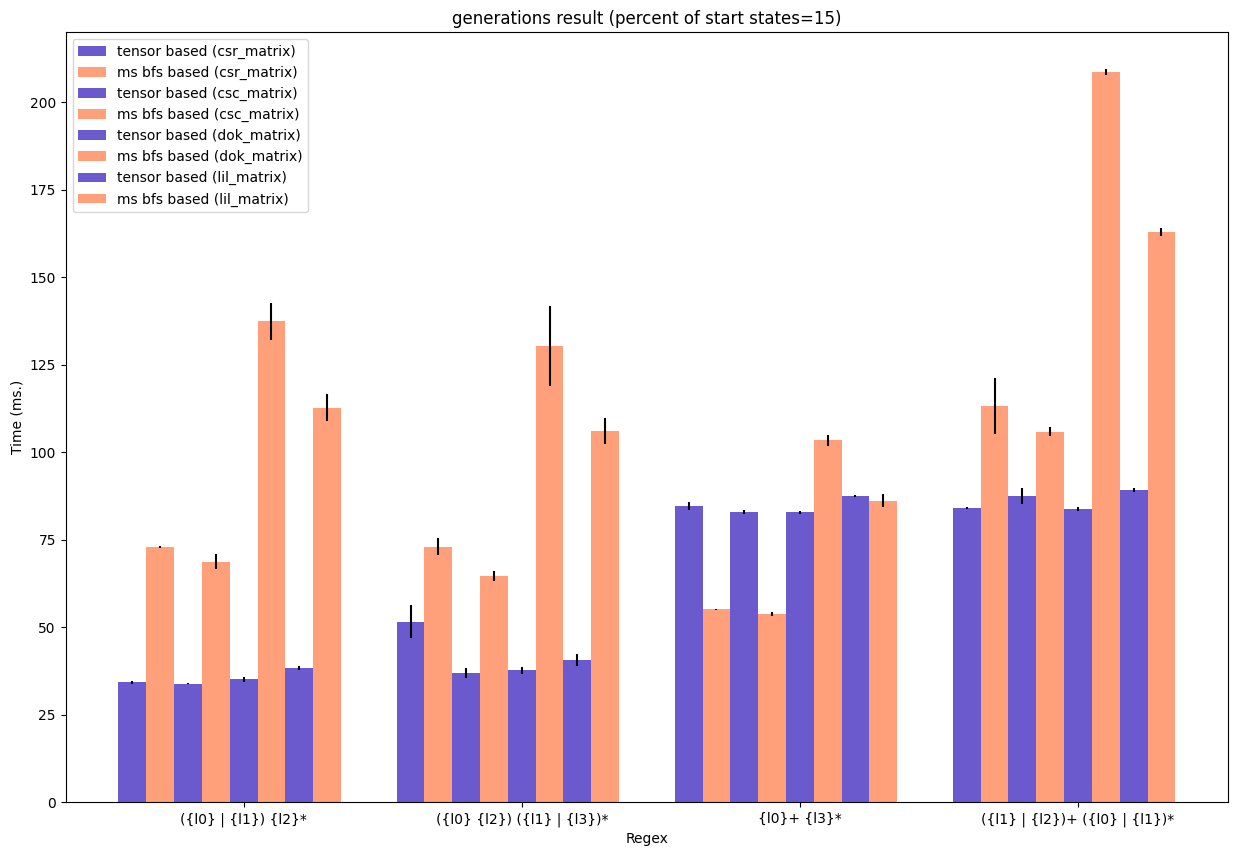

In [44]:
GRAPH_NAME = "generations"
PERCENT_OF_START_STATES = 15
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

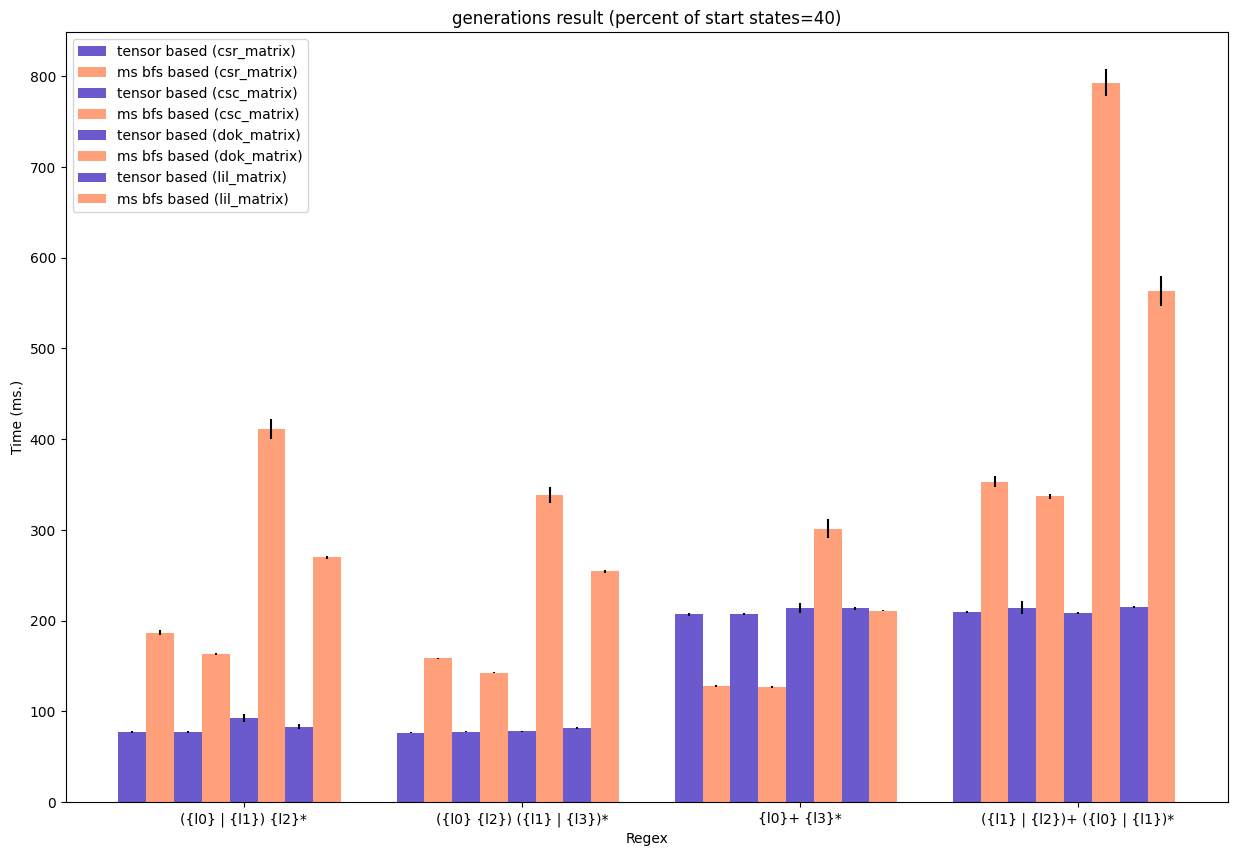

In [45]:
GRAPH_NAME = "generations"
PERCENT_OF_START_STATES = 40
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

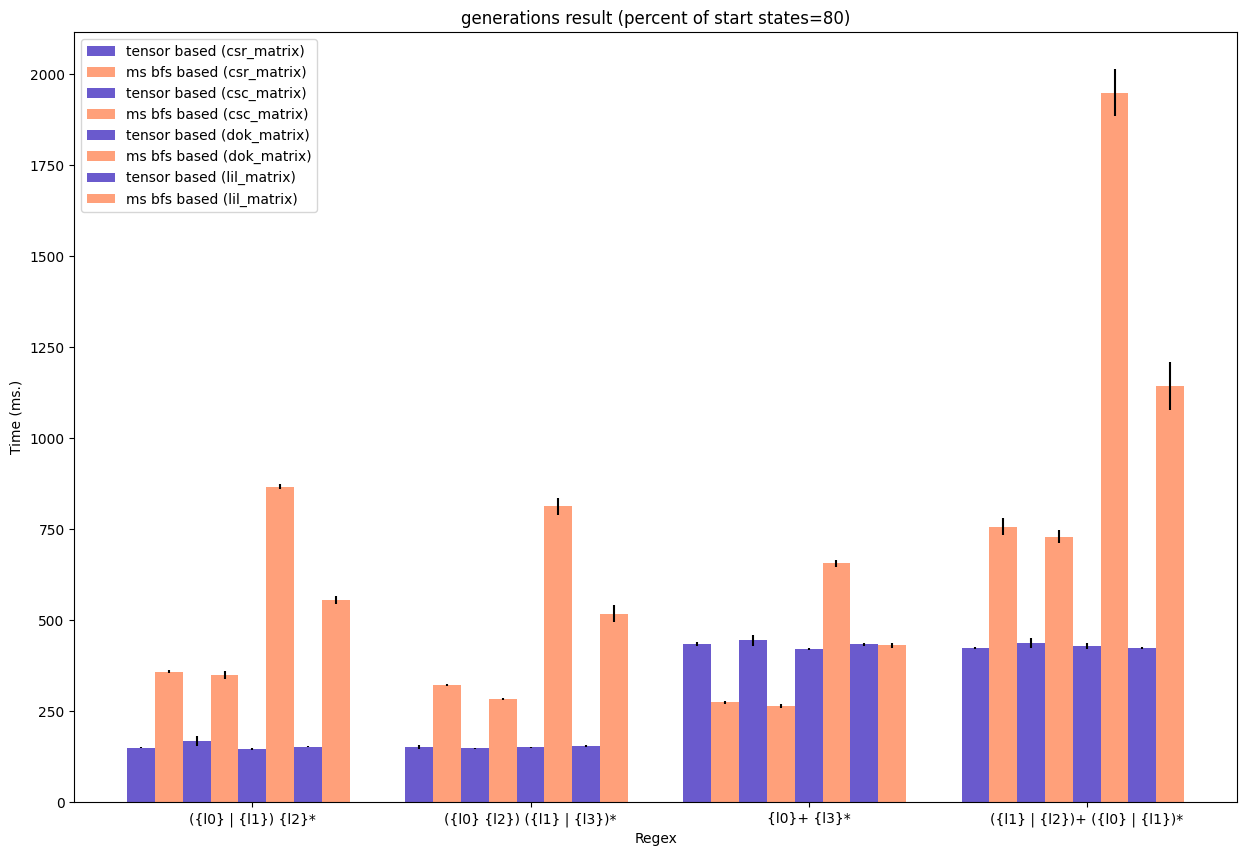

In [46]:
GRAPH_NAME = "generations"
PERCENT_OF_START_STATES = 80
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

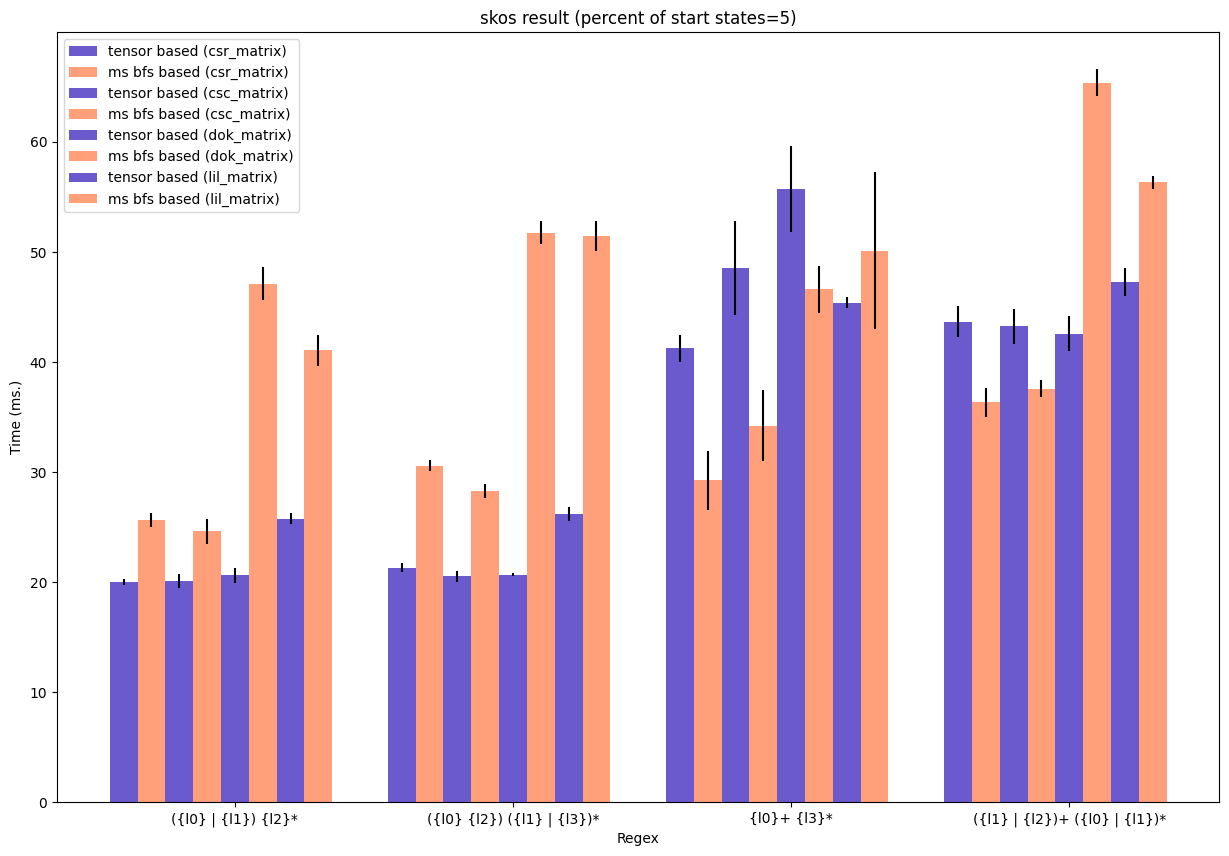

In [47]:
GRAPH_NAME = "skos"
PERCENT_OF_START_STATES = 5
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

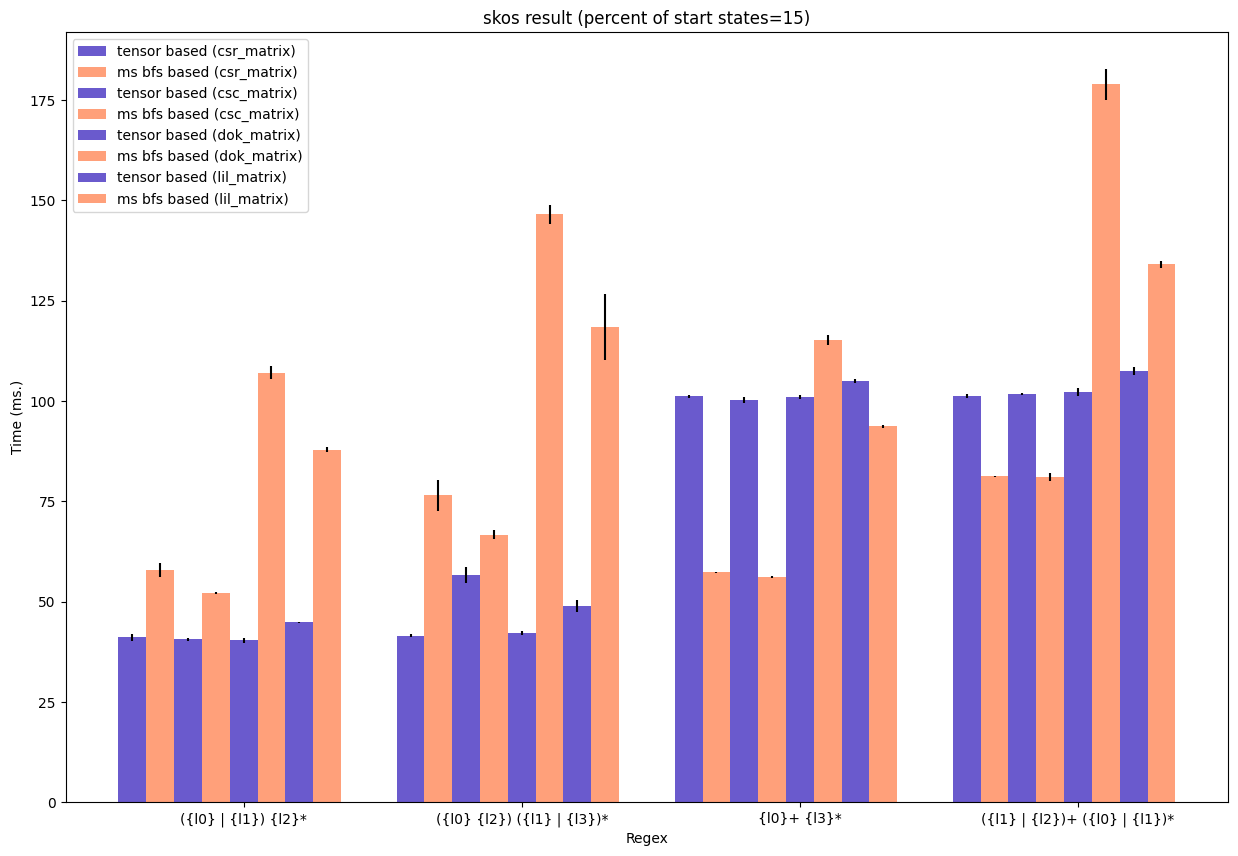

In [48]:
GRAPH_NAME = "skos"
PERCENT_OF_START_STATES = 15
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

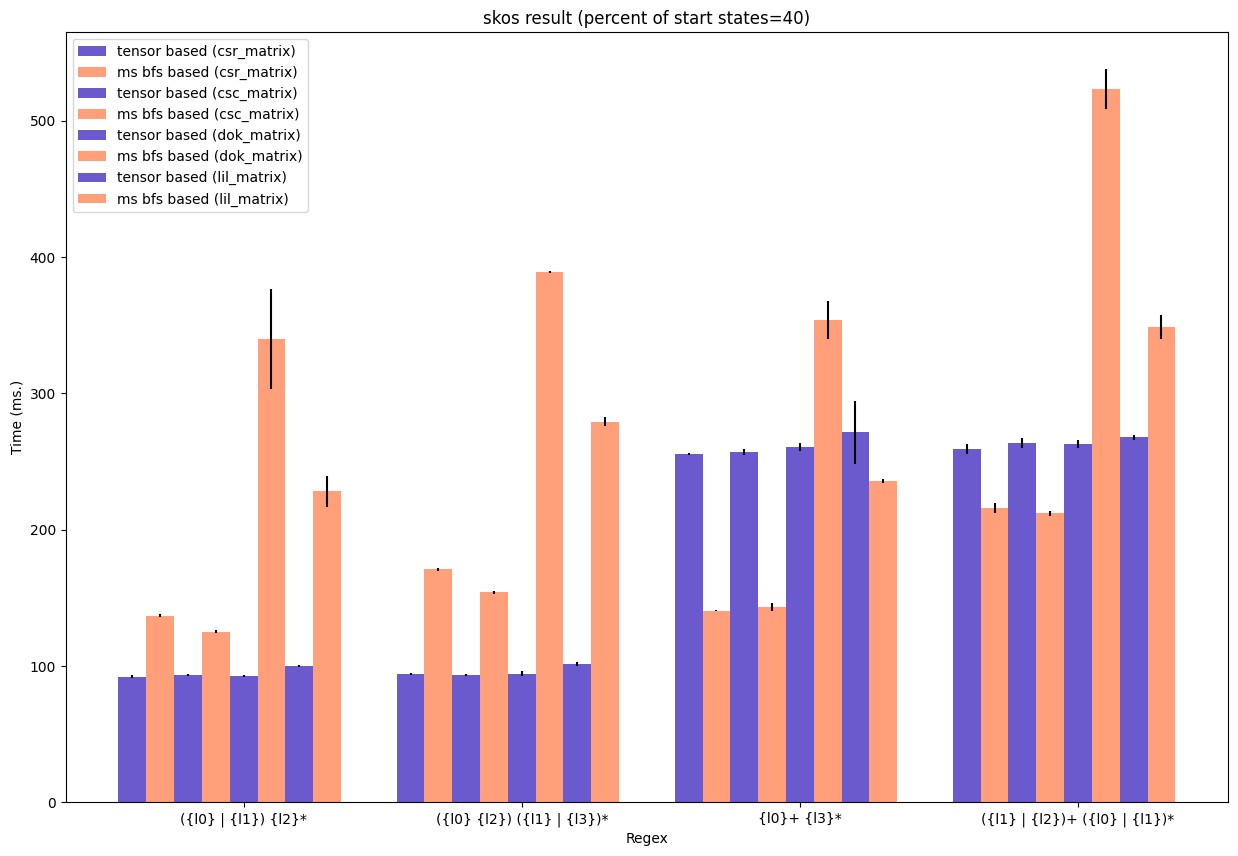

In [49]:
GRAPH_NAME = "skos"
PERCENT_OF_START_STATES = 40
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

/root/programming/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/root/programming/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


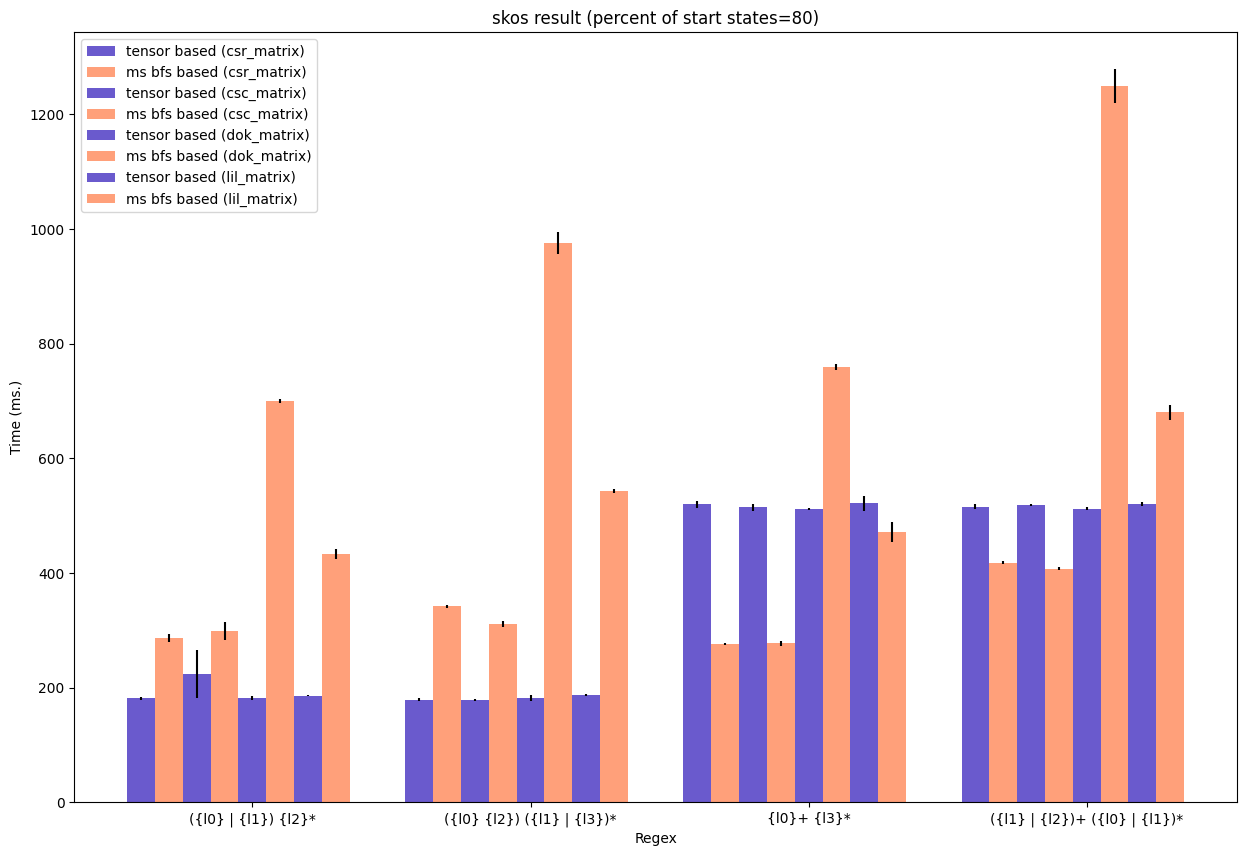

In [50]:
GRAPH_NAME = "skos"
PERCENT_OF_START_STATES = 80
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

Сложные регулярные выражения увеличивают время выполнения для обоих алгоритмов. Из графиков видно, что для малых графов с «простыми» запросами оказалось выгоднее решать задачу поиска пар, выбирая нужные из всего множества. Для «сложных» запросов оказался более производительным алгоритм ms-bfs с csr или csc. Вероятно, предпочтительный алгоритм на малых графах зависит от структуры регулярного выражения-ограничения (но, конечно, нужно рассмотреть больше примеров). Отчетливо видно весомое превосходство csr и csc форматов над остальными. Между собой же они практически равны (с любым алгоритмом). Кроме того, наблюдается низкая дисперсия результатов, что указывает на стабильность и надежность полученных измерений, позволяя сделать выводы об эффективности алгоритмов.


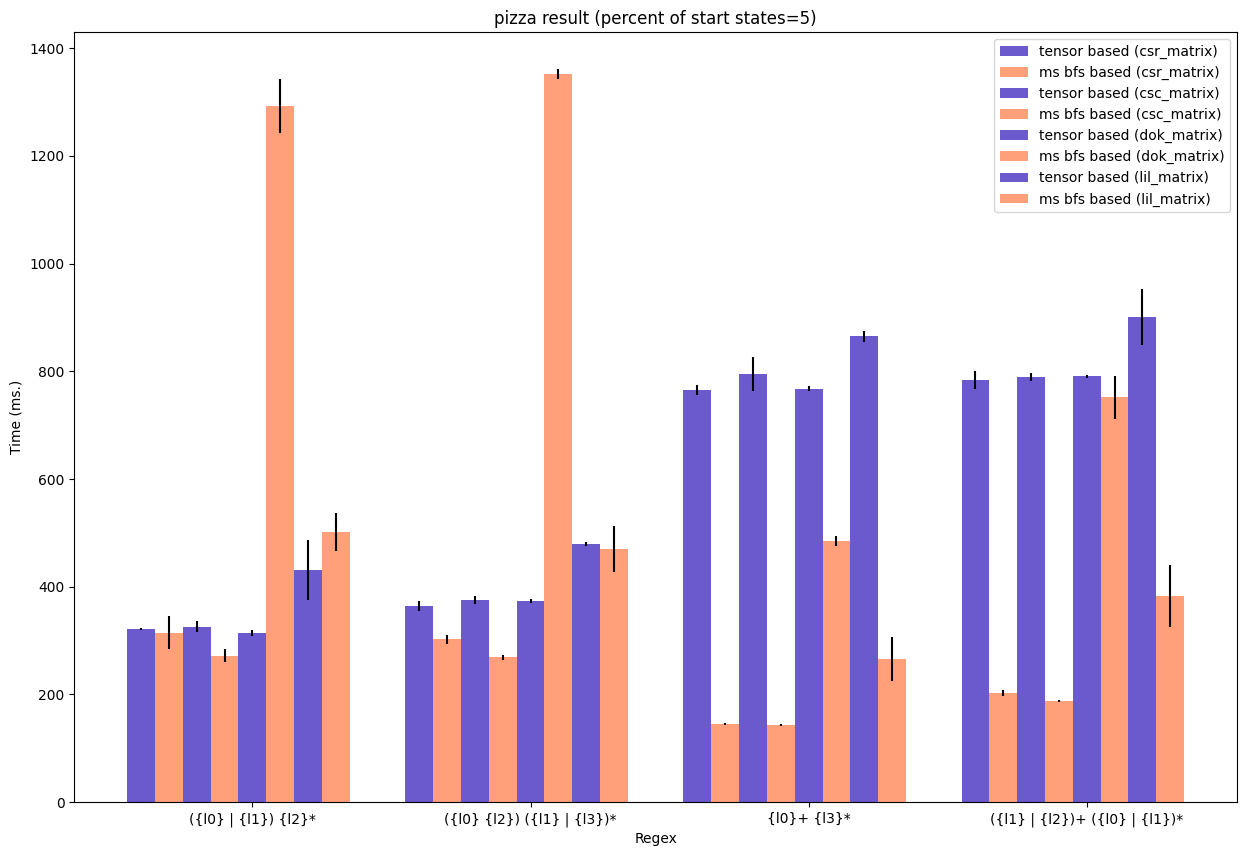

In [51]:
GRAPH_NAME = "pizza"
PERCENT_OF_START_STATES = 5
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

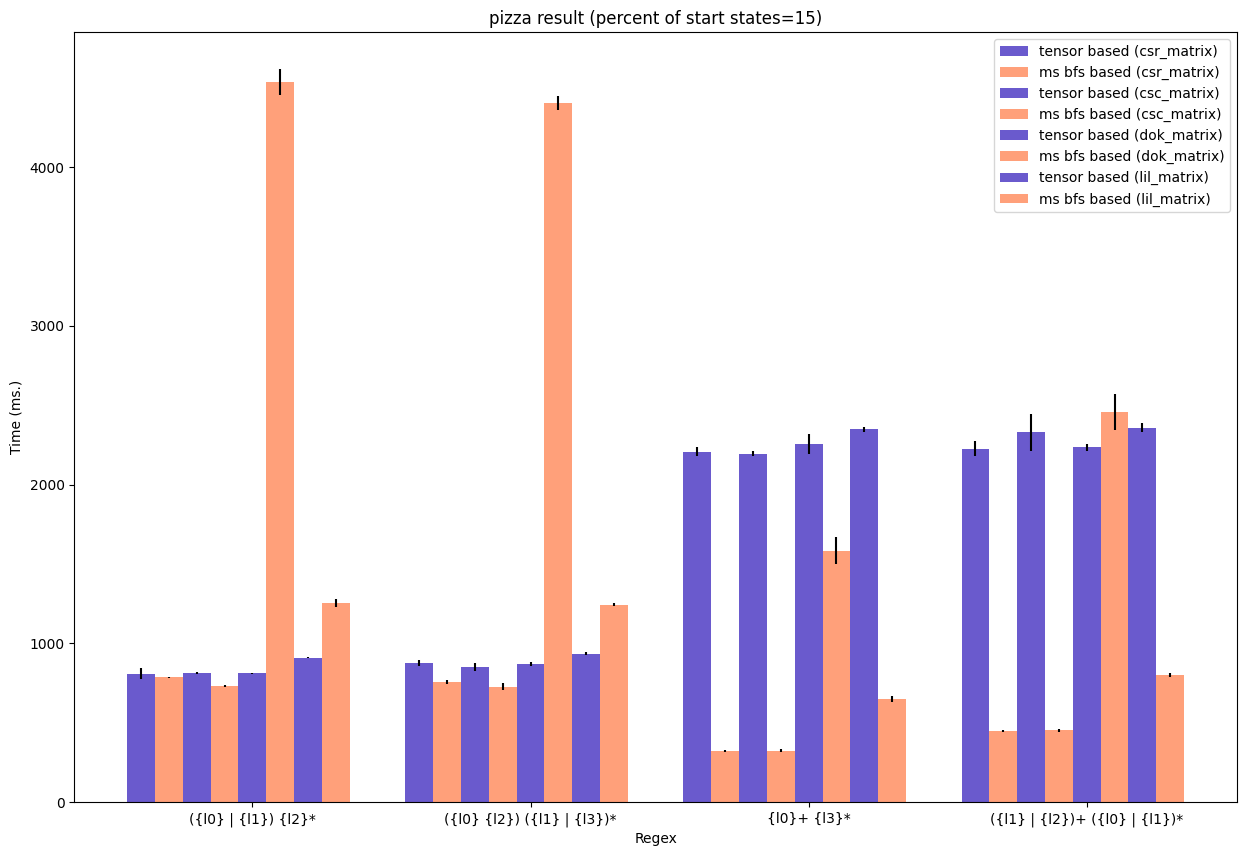

In [52]:
GRAPH_NAME = "pizza"
PERCENT_OF_START_STATES = 15
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

/root/programming/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/root/programming/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


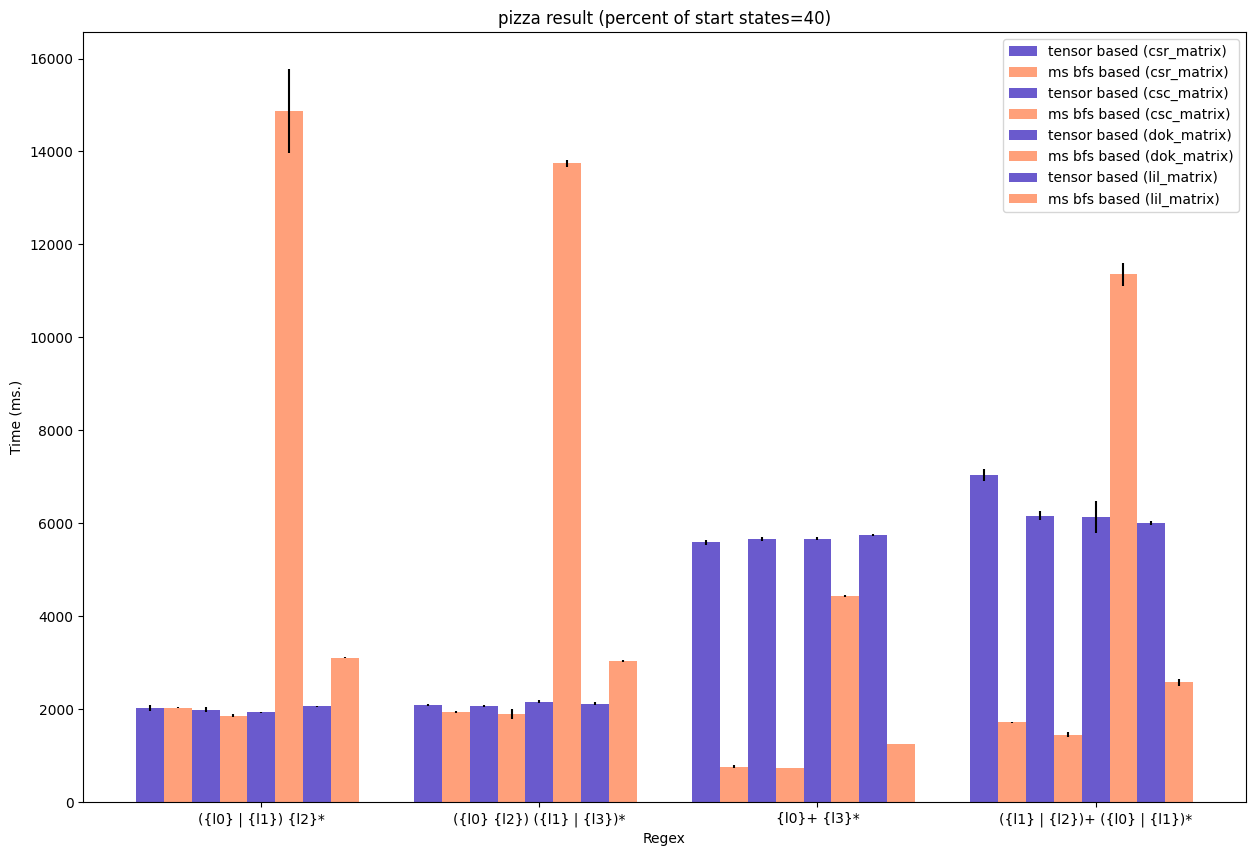

In [53]:
GRAPH_NAME = "pizza"
PERCENT_OF_START_STATES = 40
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

/root/programming/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/root/programming/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


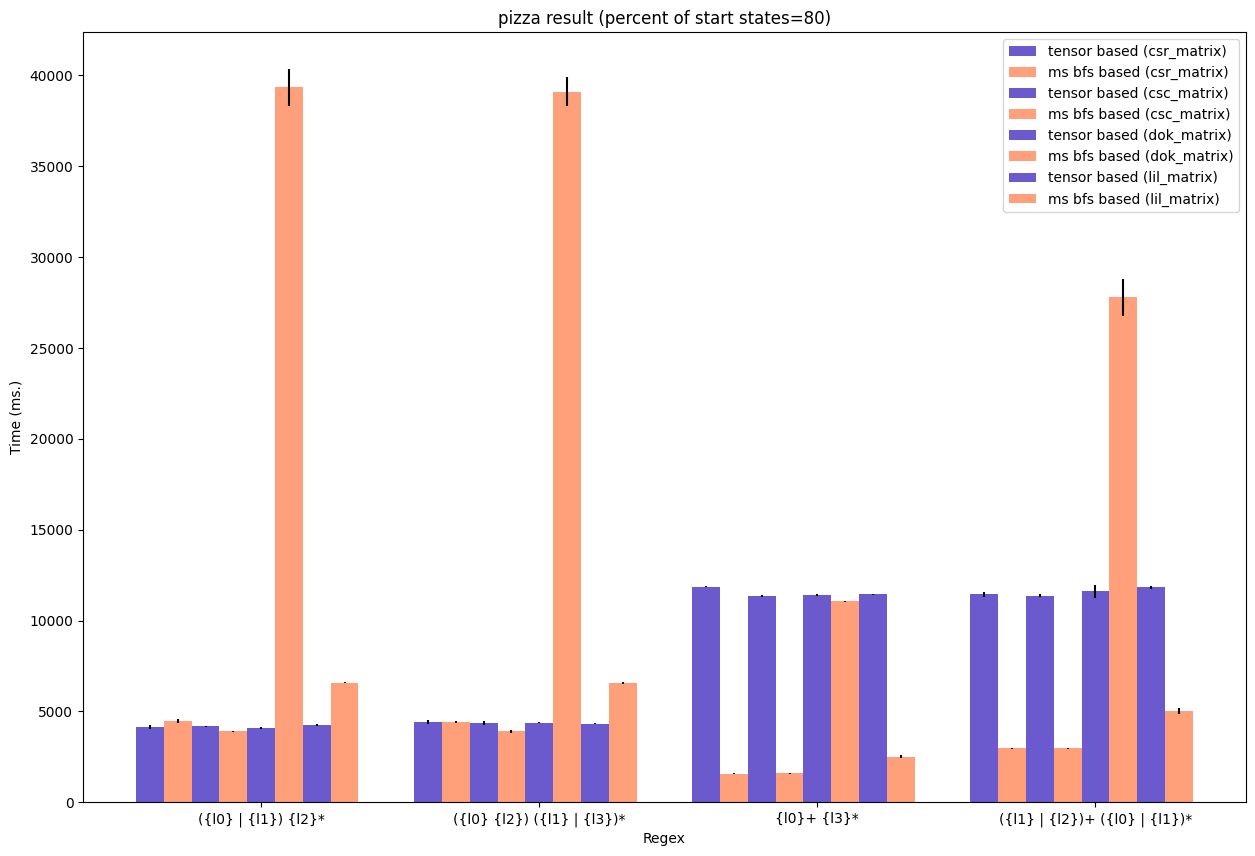

In [54]:
GRAPH_NAME = "pizza"
PERCENT_OF_START_STATES = 80
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

/root/programming/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/root/programming/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


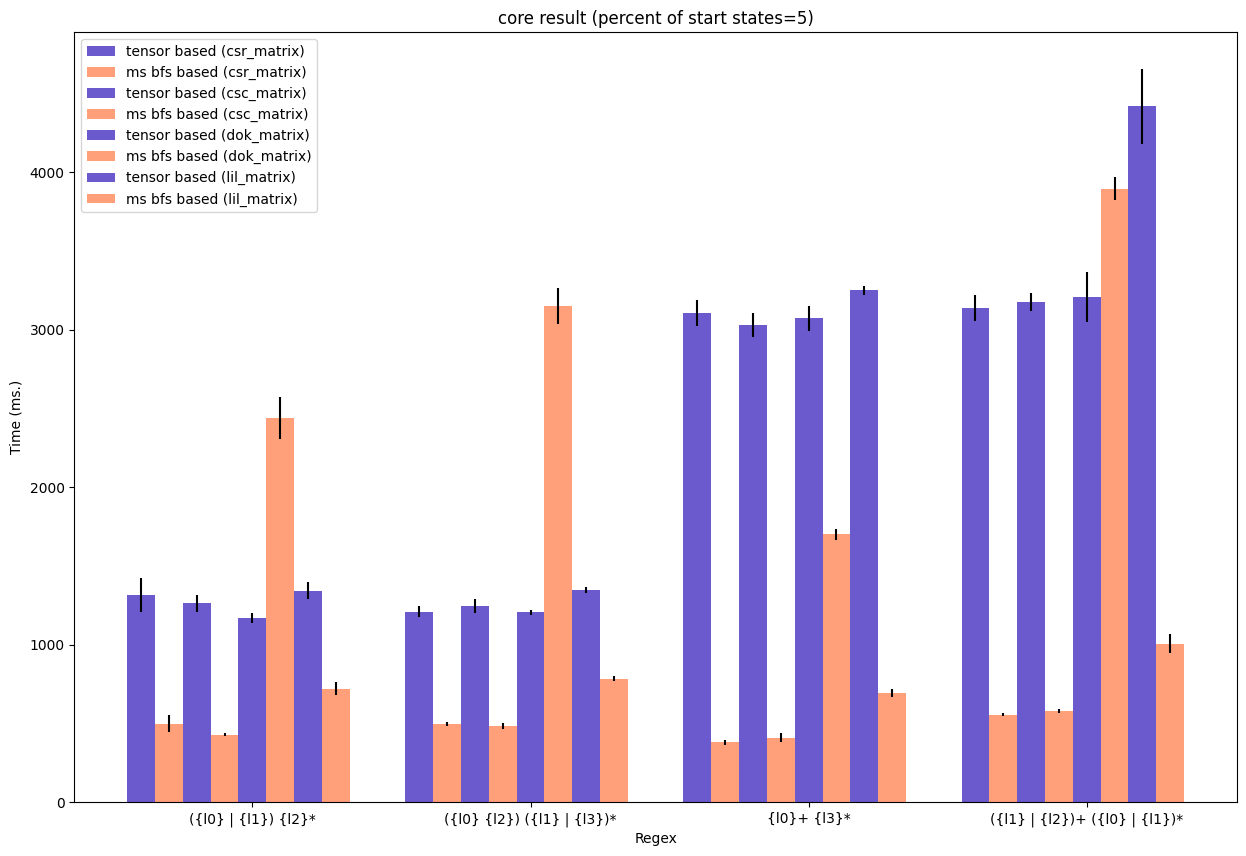

In [55]:
GRAPH_NAME = "core"
PERCENT_OF_START_STATES = 5
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

/root/programming/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/root/programming/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


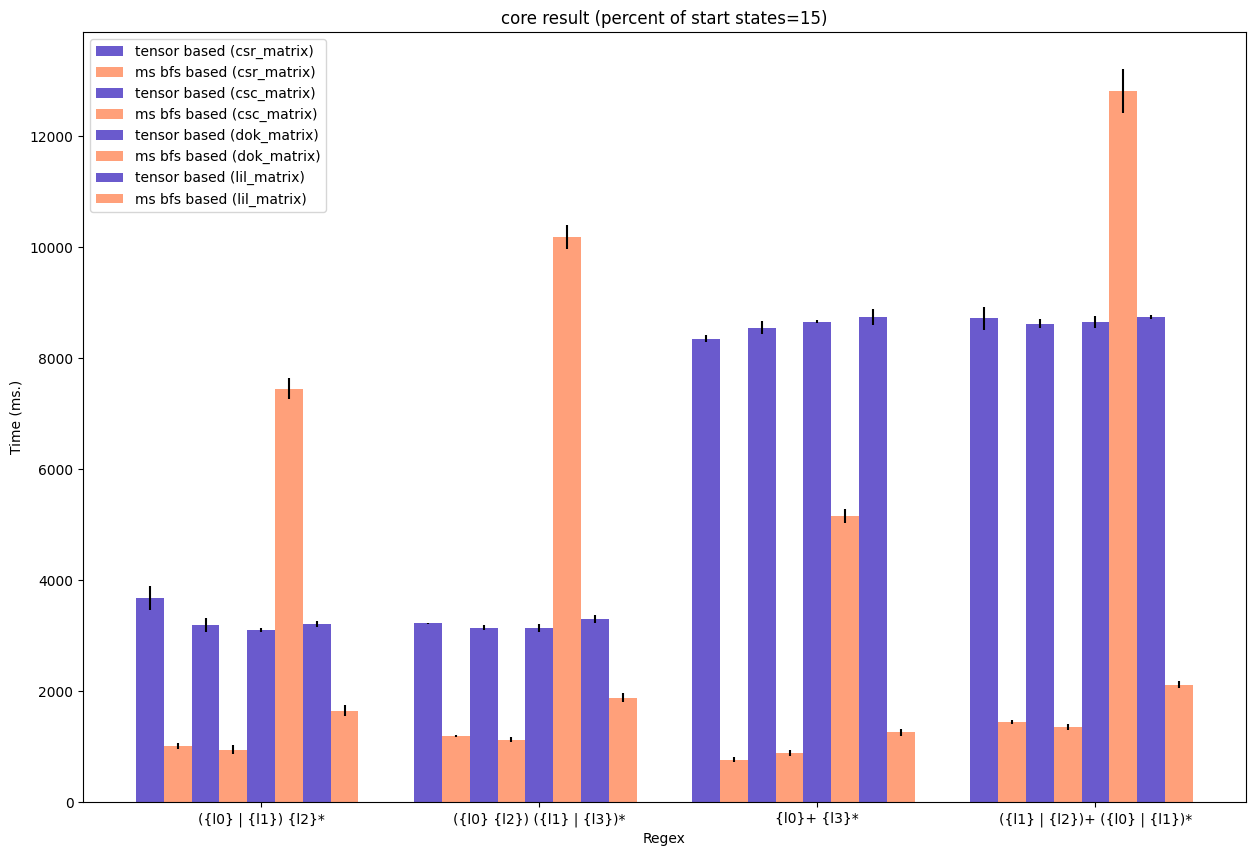

In [56]:
GRAPH_NAME = "core"
PERCENT_OF_START_STATES = 15
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

/root/programming/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/root/programming/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


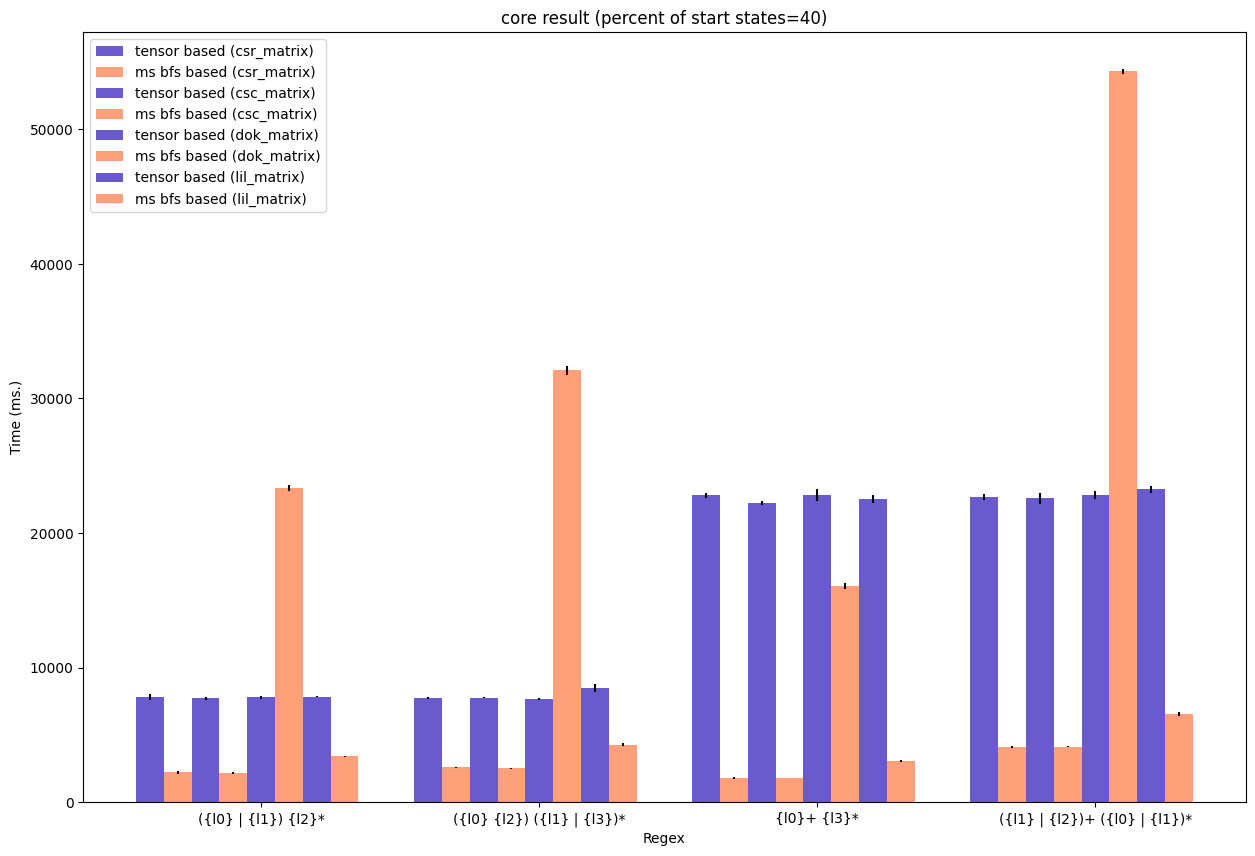

In [57]:
GRAPH_NAME = "core"
PERCENT_OF_START_STATES = 40
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

/root/programming/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)
/root/programming/formal-lang-course/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


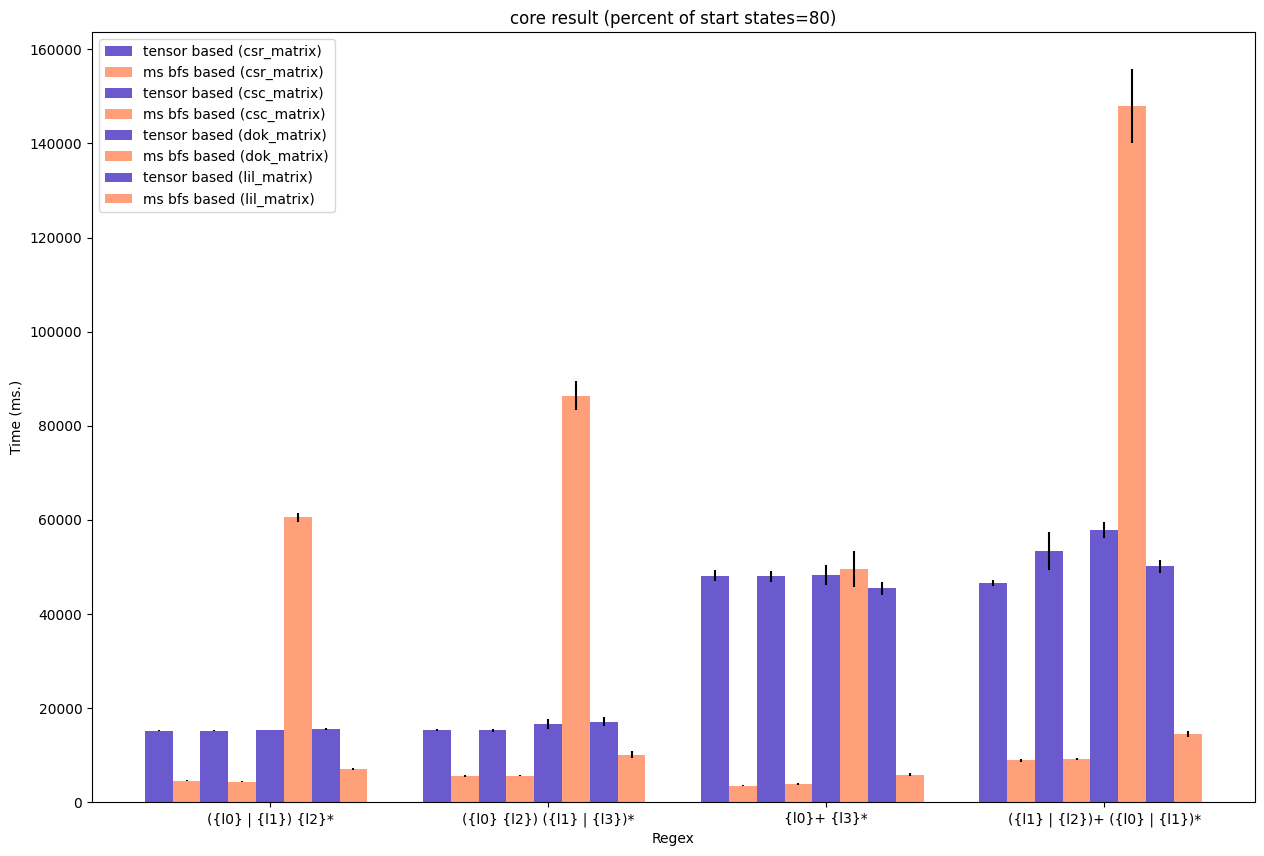

In [58]:
GRAPH_NAME = "core"
PERCENT_OF_START_STATES = 80
run_and_visualize_result(GRAPH_NAME, PERCENT_OF_START_STATES)

С графом core явно заметно превосходство алгоритма ms-bfs в любых сценариях, особенно со «сложными» регулярными ограниченями. В pizza, с «простыми» ограничениями, среди алгоритмов не было значительного превосходства, но ms-bfs оказался более производительным. Как и в случае с маленькими графами, более предпочительными вариантами остаются csr и css. Заметно, что dok_matrix стал существенно проигрывать другим форматам. Кроме того, наблюдается низкая дисперсия результатов, что указывает на стабильность и надежность полученных измерений, позволяя сделать выводы об эффективности алгоритмов.


# Анализ результатов экспериментов


### 1. Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?

Во-первых, из полученных диаграмм видно, что форматы csr и csc стабильно дают лучшие результаты, что делает их наиболее пригодными для решения этой задачи (для обоих алгоритмов). Формат dok оказался гораздо менее производительным по сравнению с остальными с алгоритмом ms_bfs, что особенно заметно на «простых» регулярных выражениях в больших графах с большим количеством начальных состояний, где разница от ближайших конкурентов может достигать целого порядка. ms_bfs c dok в ряде случаев в больших графах оказался даже менее эффективным, чем алгоритм поиска всех пар.  
lil также оказался менее эффективным, хотя его производительность выше, чем у dok. lil-матрицы оказались значительно менее эффективными по сравнению с csr и csc, а их производительность ухудшалась по мере увеличения как размера графа, так и числа стартовых вершин.

### 2. Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

Размер графа оказывает значительное влияние на производительность и на выбор оптимального алгоритма. И, возможно, структура регулярного ограничения, но из-за ограниченности выборки и сложности подбора репрезентативных вариантов сложно сказать точно. Эксперименты показали, что для малых графов с рассмотренными «простыми» запросами оказалось выгоднее решать задачу поиска пар, выбирая нужные из всего множества. Для рассмотренных «сложных» запросов оказался более производительным алгоритм ms-bfs.
